# Graph Creation

In [134]:
%cd /home/ltchen/gnnpp
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils import to_networkx
from scipy.interpolate import interp1d
from utils.data import *
from utils.plot import plot_map
from torch_geometric.utils import is_undirected, degree, contains_isolated_nodes

/home/ltchen/gnnpp


### Data Loading

In [32]:
dfs = load_dataframes(mode="train", leadtime="24h")
stations = dfs["stations"] # add orography into stations
df_target = dfs['train'][1]
df = dfs['train'][0]
df_target
df_target[df_target.time == "1997-01-02"].head()
stations

[INFO] Dataframes exist. Will load pandas dataframes.


,station_id,lat,lon,altitude,orog,name
0,235,52.928000,4.781000,1.2,-1.706008,De Kooy
1,240,52.318000,4.790000,-3.3,-1.298122,Schiphol
2,242,53.241000,4.921000,10.8,0.333424,Vlieland
3,251,53.392000,5.346000,0.7,1.302155,Hoorn (Terschelling)
4,260,52.100000,5.180000,1.9,2.576800,De Bilt
...,...,...,...,...,...,...
117,7460,45.786833,3.149333,331.0,521.714299,Clermont-Fd
118,11101,47.499168,9.746111,424.0,689.253673,Bregenz
119,11105,47.266666,9.600000,439.0,972.938723,Feldkirch
120,11308,47.255833,10.186111,1478.0,1752.460782,Warth


### Functions

In [147]:
def signed_difference(x, y): # macht es Sinn signed difference zu benutzen?
    return x - y

def dist_km(lat1: float = 0, lon1: float = 0, lat2: float = 0, lon2: float = 0) -> float:
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km

def signed_geodesic_km(lat1: float = 0, lon1: float = 0, lat2: float = 0, lon2: float = 0) -> float:
    if lat1 > lat2 or lon1 > lon2:
        dist = geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km
    else:
        dist = -1 * geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km
    return dist

def create_emp_cdf(station_temps):  # F_i(x)
    data_sorted = np.sort(station_temps)
    cdf = np.arange(len(data_sorted)) / len(data_sorted)
    cdf_function = interp1d(data_sorted, cdf, kind='previous', bounds_error=False, fill_value=(0, 1))
    return cdf_function

def dist2(i_id, j_id, train_set):
# def dist2(i_id, j_id):
    # print(i_id, j_id)
    i_train_temps = train_set[train_set['station_id'] == i_id]['t2m']
    j_train_temps = train_set[train_set['station_id'] == j_id]['t2m']
    F_i = create_emp_cdf(i_train_temps)
    F_j = create_emp_cdf(j_train_temps)
    sum = 0
    S = np.arange(train_set['t2m'].min(), train_set['t2m'].max(), 1)
    for x in S:
        sum += abs(F_i(x) - F_j(x))
    d2 = sum * 1/S.shape[0]
    return d2

# def compute_d2_matrix(stations: pd.DataFrame, df: pd.DataFrame) -> np.array:
    # macht es Sinn, dass trainset hier hinzugegeben wird fuer die graphenerstellung?
def compute_d2_matrix(stations: pd.DataFrame) -> np.array:
    station_id = np.array(stations.index).reshape(-1, 1)
    # print(station_id.shape)
    # print(station_id.T.shape)
    vectorized_dist2 = np.vectorize(dist2, excluded=[2])
    distance_matrix = vectorized_dist2(station_id, station_id.T, dfs['train'][0])
    # distance_matrix = np.vectorize(dist2)(station_id, station_id.T)
    return distance_matrix

def load_d2_distances(stations: pd.DataFrame) -> np.ndarray:
    if os.path.exists("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy"):
        print("[INFO] Loading distances from file...")
        mat = np.load("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy")
    else:
        print("[INFO] Computing distances...")
        mat = compute_d2_matrix(stations)
        np.save("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy", mat)
    return mat



In [148]:
def compute_mat(df: pd.DataFrame, mode: str) -> np.array:
    if mode == "geo":
        lon = np.array(df["lon"].copy())
        lat = np.array(df["lat"].copy())
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)
        distance_matrix = np.vectorize(dist_km)(lat_mesh, lon_mesh, lat_mesh.T, lon_mesh.T)
    if mode == "alt":
        altitude = np.array(df["altitude"].copy())
        mesh1, mesh2 = np.meshgrid(altitude, altitude)
        distance_matrix = np.vectorize(signed_difference)(mesh1, mesh2) # zwei vektoren voneinander abziehen
    if mode == "alt-orog":
        altorog = np.array((df['altitude']-df['orog']).copy())
        mesh1, mesh2 = np.meshgrid(altorog, altorog)
        distance_matrix = np.vectorize(signed_difference)(mesh1, mesh2)
    if mode == "lon":
        lon = np.array(df["lon"].copy())
        mesh1, mesh2 = np.meshgrid(lon, lon)
        distance_matrix = np.vectorize(signed_geodesic_km)(lon1 =mesh1, lon2=mesh2)
    if mode == "lat":
        lat = np.array(df["lat"].copy())
        mesh1, mesh2 = np.meshgrid(lat, lat) # check if this meshgrid actually works!!
        distance_matrix = np.vectorize(signed_geodesic_km)(lat1=mesh1, lat2=mesh2) # vorzeichen!
    if mode == "dist2":
        distance_matrix = load_d2_distances(dfs['stations'])
    if mode == "dist3":
        distance_matrix = load_d3_distances(dfs['stations'])
    return distance_matrix

def get_adj(dist_matrix_sliced: np.array, max_dist: float = 50) -> np.array:
    mask = None
    mask = (dist_matrix_sliced <= max_dist) & (dist_matrix_sliced >= (-max_dist))
    diagonal = np.full((mask.shape[0], mask.shape[1]), True, dtype=bool)
    np.fill_diagonal(diagonal, False)
    mask = np.logical_and(mask, diagonal)
    return mask

# def create_graph(attributes: list, edges: list, date: str, ensemble: int, summary_stats: bool = False): # generic create_graph function
# list of tubles (attribute name & max)

def create_graph_data(date: str, ensemble: int, sum_stats: bool = False):
    day = df[df.time == date]
    ens = day[day.number == ensemble] # only if sum_stats = Fals
    ens = ens.drop(columns=["time", "number"])
    x = torch.tensor(ens.to_numpy(dtype=np.float32))

    target = df_target[df_target.time == date]
    target = target.drop(columns=["time", "station_id"]).to_numpy()
    y = torch.tensor(target)

    lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
    # print(lon.shape)
    lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
    # print(lat.shape)
    pos = np.concatenate([lon, lat], axis=1).reshape(-1, 2)
    pos_dict = dict(enumerate(pos))

    return x, y, pos_dict, (lon, lat)

In [126]:
def create_graph(attributes: list, edges: list, date: str, ensemble: int, sum_stats: bool = False):
    x, y, pos_dict, (lon, lat) = create_graph_data(date, ensemble, sum_stats)
    # assert all elements in edges exist in attributes!
    first_el = [t[0] for t in edges]
    assert set(attributes).issuperset(set(first_el)), "edges are created based on attributes."

    # attribute tensor creation
    t_dim = len(attributes)
    attr_tensor = torch.empty((122, 122, t_dim), dtype=torch.float32)
    for i, list_element in enumerate(attributes):
        # compute distance matrix
        attr_tensor[:,:,i] = torch.tensor(compute_mat(dfs['stations'], list_element))

    attr_mask = torch.empty(122, 122, len(edges))
    for i, el in enumerate(edges):
        attr, max_value = el
        # position von attr in der attribute liste => welche distance matrix in tensor
        pos = attributes.index(attr)
        attr_mask[:,:,i] = get_adj(attr_tensor[:, :, pos], max_dist=max_value)

    g_adj = attr_mask.any(dim=2)
    g_edges = np.array(np.argwhere(g_adj))
    g_edge_idx = torch.tensor(g_edges.T)
    g_edge_attr = attr_tensor[g_adj]

    # standardization
    max_edge_attr = g_edge_attr.max(dim=0).values
    std_g_edge_attr = g_edge_attr / max_edge_attr

    graph = Data(x=x, edge_index=g_edge_idx.T, edge_attr=std_g_edge_attr, timestamp=date, y=y)
    return graph, pos_dict



In [143]:
def facts_about(graph):
    n_nodes = graph.num_nodes
    n_edges = graph.num_edges
    node_degrees = degree(graph.edge_index[0], num_nodes=n_nodes)
    avg_degree = node_degrees.mean().item()
    n_isolated_nodes = (node_degrees == 0).sum().item()
    feature_dim = graph.x.size(1)
    edge_dim = graph.num_edge_features

    print(f"Number of nodes: {n_nodes} with feature dimension of x: {feature_dim}")
    print(f"Number of isolated nodes: {n_isolated_nodes}")
    print(f"Number of edges: {n_edges} with edge dimension: {edge_dim}")
    print(f"Average node degree: {avg_degree}")

## Graph 1: Distance based

(122, 1)
(122, 1)
1420
2
test


<Figure size 1000x1000 with 0 Axes>

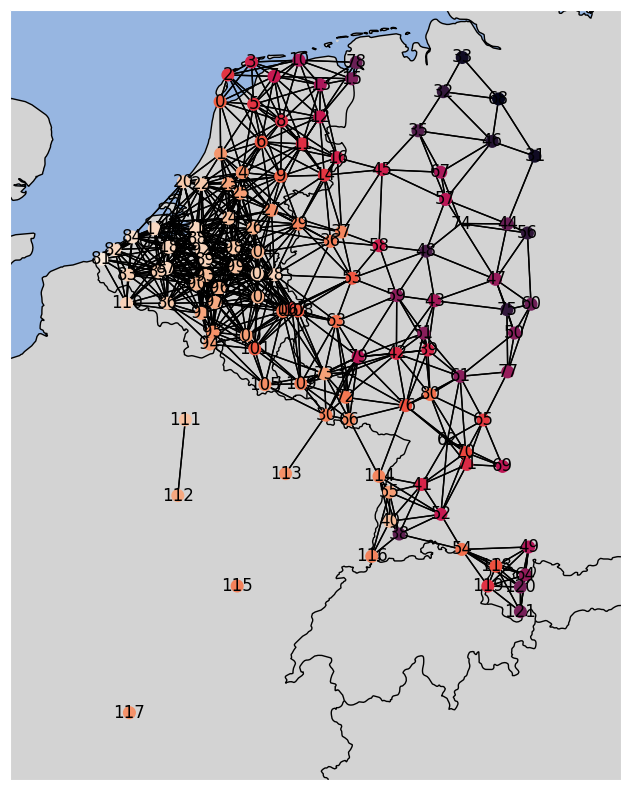

In [127]:
graph_1, pos_dict = create_graph(attributes=["geo", "alt"], edges=[("geo", 100)], date='1997-01-02', ensemble=0, sum_stats=False)

# "dist2", "dist3", "dist4"
print(graph_1.num_edges)
print(graph_1.num_edge_features)
vis = to_networkx(graph_1)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph_1.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

In [144]:
facts_about(graph_1)

Number of nodes: 122 with feature dimension of x: 34
Number of isolated nodes: 2
Number of edges: 1420 with edge dimension: 2
Average node degree: 11.639344215393066


## Graph 2: Altitude based

Number of nodes: 122 with feature dimension of x: 34
Number of isolated nodes: 17
Number of edges: 1036 with edge dimension: 2
Average node degree: 8.491803169250488
test


<Figure size 1000x1000 with 0 Axes>

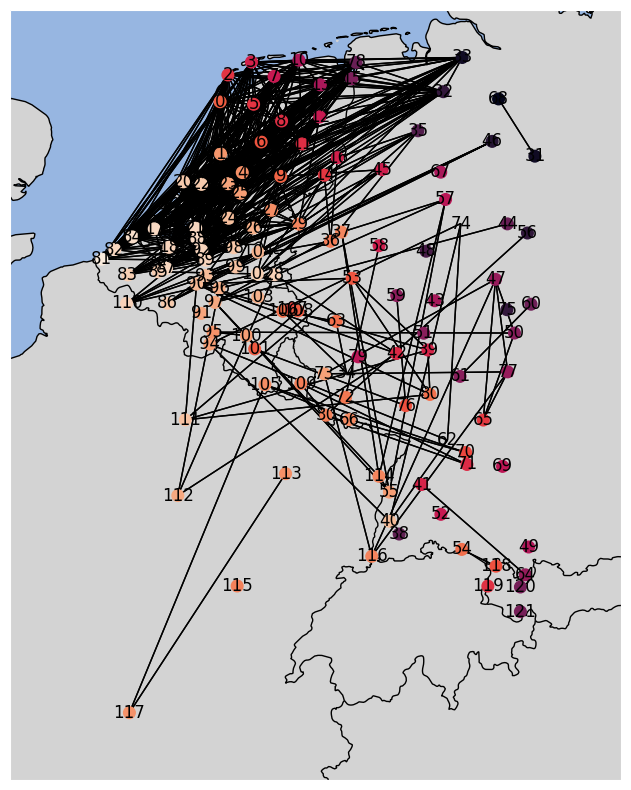

In [150]:
graph_2, pos_dict = create_graph(attributes=["geo", "alt"], edges=[("alt", 10)], date='1997-01-02', ensemble=0, sum_stats=False)

facts_about(graph_2)
vis = to_networkx(graph_2)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph_2.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

## Graph 3: Distance and Altitude

(122, 1)
(122, 1)
[INFO] Loading distances from file...
2154
4
test


<Figure size 1000x1000 with 0 Axes>

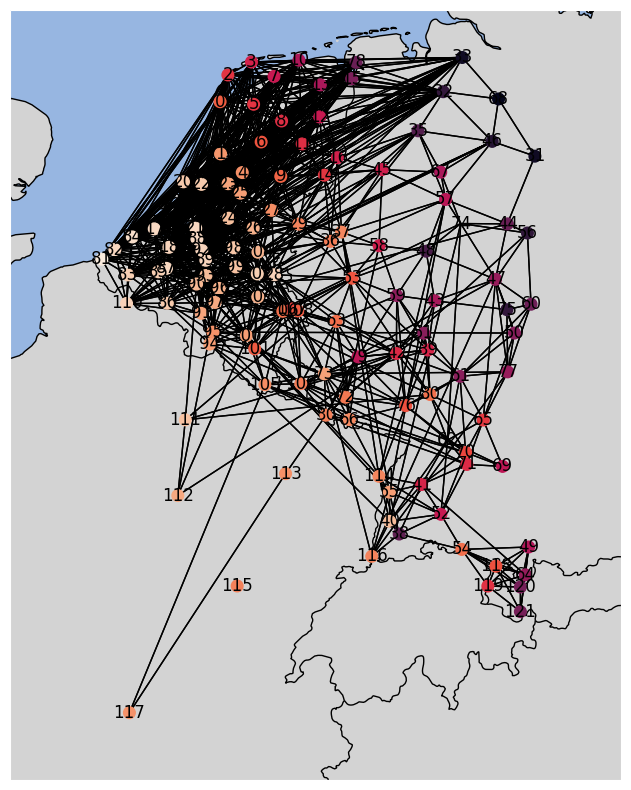

In [129]:
graph_3, pos_dict = create_graph(attributes=["geo", "alt", "alt-orog", "dist2"], edges=[("geo", 100), ("alt", 10)], date='1997-01-02', ensemble=0, sum_stats=False)

print(graph_3.num_edges)
print(graph_3.num_edge_features)
vis = to_networkx(graph_3)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph_3.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

## Graph 4: Alt-orog

(122, 1)
(122, 1)
[INFO] Loading distances from file...
514
6
test


<Figure size 1000x1000 with 0 Axes>

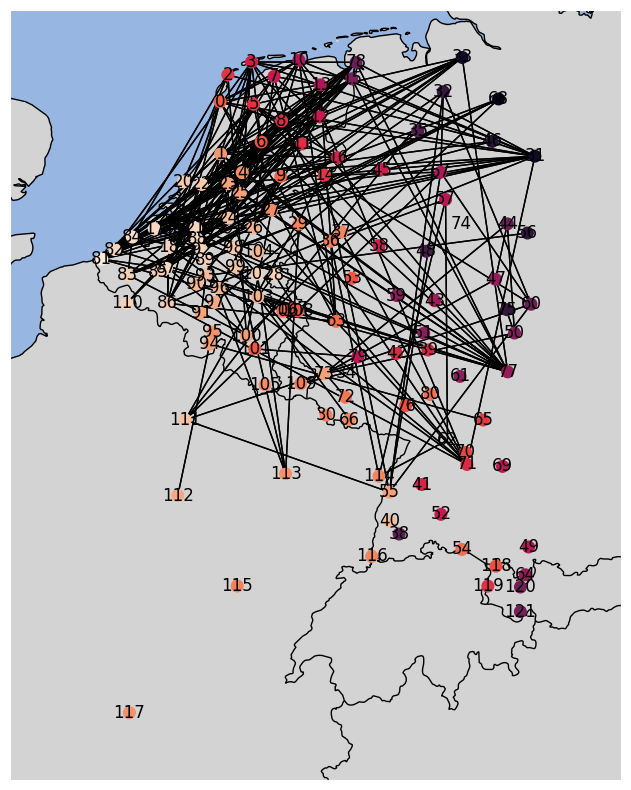

In [130]:
graph_4, pos_dict = create_graph(attributes=["geo", "alt", "dist2", "alt-orog", "lon", "lat"], edges=[("alt-orog", 2)], date='1997-01-02', ensemble=0, sum_stats=False)

print(graph_4.num_edges)
print(graph_4.num_edge_features)
vis = to_networkx(graph_4)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph_4.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

## Graph 5: Dist2 metric

In [131]:
attributes=["geo", "alt", "alt-orog", "lon", "lat", "dist2"]
edges=[("geo", 100), ("alt", 10)]

(122, 1)
(122, 1)
[INFO] Loading distances from file...
928
6
test


<Figure size 1000x1000 with 0 Axes>

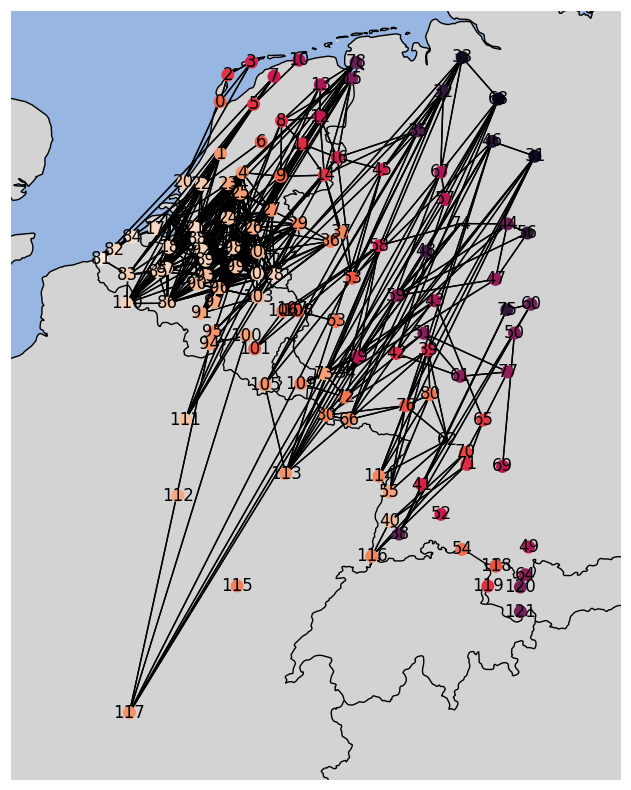

In [132]:
graph_5, pos_dict = create_graph(attributes=attributes, edges=[("dist2", 0.004)], date='1997-01-02', ensemble=0, sum_stats=False)

# "dist2", "dist3", "dist4"
print(graph_5.num_edges)
print(graph_5.num_edge_features)
vis = to_networkx(graph_5)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph_5.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

## Graph 6: Dist3 metric

# Exploration

In [11]:
# create data object for one ensemble member (should all be the same)
date = '1997-01-02'
print(type(date))
day = df[df.time == date]
ensemble = 0
first_ens = day[day.number == ensemble]
first_ens = first_ens.drop(columns=["time", "number"])
x = torch.tensor(first_ens.to_numpy(dtype=np.float32))

target = df_target[df_target.time == date]
target = target.drop(columns=["time", "station_id"]).to_numpy()
y = torch.tensor(target)
#print(type(target))

lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
print(lon.shape)
lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
print(lat.shape)
pos = np.concatenate([lon, lat], axis=1).reshape(-1, 2)
pos_dict = dict(enumerate(pos))

# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)

<class 'str'>
(122, 1)
(122, 1)


## Altitude

### Graph 1
edges based on dist, num_attr = 1

In [5]:
max_geo = 100
geo_dist = compute_mat(dfs['stations'], "geodesic")
print(geo_dist)
geo_mask = get_adj(geo_dist, max_geo)
print(geo_mask.sum())

[[  0.          67.88302104  36.07414311 ... 717.54863254 739.55923355
  767.55524464]
 [ 67.88302104   0.         103.0930141  ... 659.66900567 683.69191062
  710.83747663]
 [ 36.07414311 103.0930141    0.         ... 743.23584479 763.87800296
  792.39252869]
 ...
 [717.54863254 659.66900567 743.23584479 ...   0.          44.37574719
   55.46816552]
 [739.55923355 683.69191062 763.87800296 ...  44.37574719   0.
   31.99306735]
 [767.55524464 710.83747663 792.39252869 ...  55.46816552  31.99306735
    0.        ]]
1420


In [6]:
geo_adj = torch.tensor(geo_mask)
geo_d = torch.tensor(geo_dist)
print(geo_d.shape)


torch.Size([122, 122])


In [7]:
# create edges
geo_edges = np.array(np.argwhere(geo_adj))
print(geo_edges.shape)
geo_edge_idx = torch.tensor(geo_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {geo_edge_idx.shape}")
print(f"Edges: {geo_edge_idx}")
print(f"Total number of edges: {np.sum(geo_adj.numpy())}")

(2, 1420)
Edges shape: torch.Size([1420, 2])
Edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])
Total number of edges: 1420


In [8]:
# add attributes - standardize after mask application
geo_attr = geo_d[geo_adj]
geo_edge_attr = geo_attr / geo_attr.max()
geo_edge_attr = torch.tensor(geo_edge_attr.reshape(-1, 1))
print(geo_edge_attr)
print(geo_edge_attr.shape)

tensor([[0.6801],
        [0.3614],
        [0.6411],
        ...,
        [0.6791],
        [0.5557],
        [0.3205]], dtype=torch.float64)
torch.Size([1420, 1])


/tmp/ipykernel_1070060/4292533922.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geo_edge_attr = torch.tensor(geo_edge_attr.reshape(-1, 1))


In [9]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(geo_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {geo_edge_idx.shape}")
print(f"edge_attr: {geo_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([1420, 2])
edge_attr: torch.Size([1420, 1])
y: torch.Size([122, 1])
pos: (122, 2)


In [10]:
graph1 = Data(x=x, edge_index=geo_edge_idx.T, edge_attr=geo_edge_attr, timestamp=date, y=y)
#graph1
print(graph1.num_edges)
print(type(graph1))
print(graph1.num_edge_features)

1420
<class 'torch_geometric.data.data.Data'>
1


test


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y', 'edge_attr', 'timestamp', 'x'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


<Figure size 1000x1000 with 0 Axes>

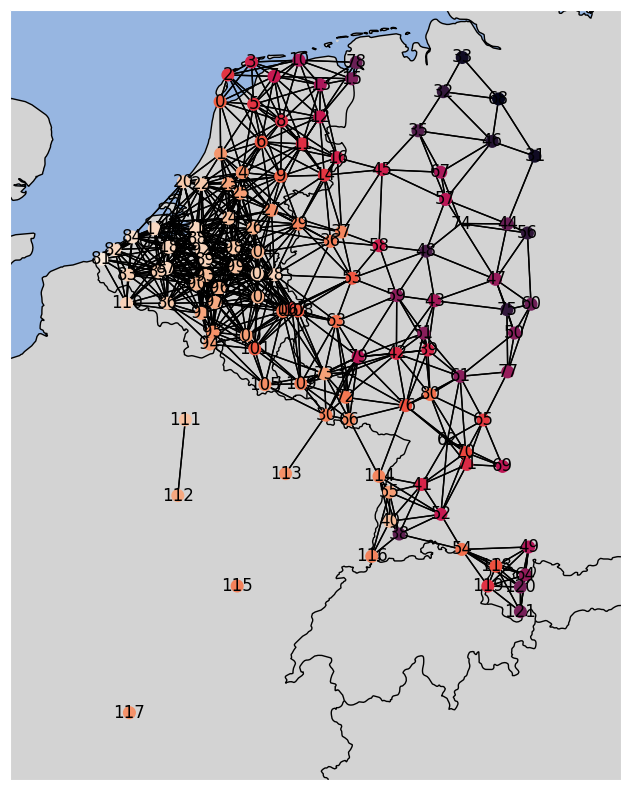

In [17]:
vis = to_networkx(graph1)
plt.figure(1, figsize=(10, 10))
ax = plot_map() # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size = 70, node_color = graph1.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Graph 2: alt + dist
edges based on dist, num_attr = 2

In [25]:
max_alt = 10 # in welcher einheit (meters above sea level)
alt_dist = compute_mat(dfs["stations"], "altitude")
print(alt_dist)

#alt_mask = get_adj(alt_dist, max_dist=max_alt)
#print(alt_mask.sum())

[[    0.     -4.5     9.6 ...   437.8  1476.8  1585.8]
 [    4.5     0.     14.1 ...   442.3  1481.3  1590.3]
 [   -9.6   -14.1     0.  ...   428.2  1467.2  1576.2]
 ...
 [ -437.8  -442.3  -428.2 ...     0.   1039.   1148. ]
 [-1476.8 -1481.3 -1467.2 ... -1039.      0.    109. ]
 [-1585.8 -1590.3 -1576.2 ... -1148.   -109.      0. ]]


In [26]:
g2_adj = torch.tensor(geo_mask)
geo_d = torch.tensor(geo_dist).unsqueeze(dim = 2)
alt_d = torch.tensor(alt_dist).unsqueeze(dim = 2)
print(alt_d.shape)

dist_tensor = torch.cat([geo_d, alt_d], dim=2) # O-W und N-S Attribut noch rein
print(dist_tensor.shape)

torch.Size([122, 122, 1])
torch.Size([122, 122, 2])


In [27]:
# create edges
#adj_mat = g2_adj

g2_edges = np.array(np.argwhere(g2_adj))
print(g2_edges.shape)
g2_edge_idx = torch.tensor(g2_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {g2_edge_idx.shape}")
print(f"Edges: {g2_edge_idx}")
print(f"Total number of edges: {np.sum(g2_adj.numpy())}")

(2, 1420)
Edges shape: torch.Size([1420, 2])
Edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])
Total number of edges: 1420


In [38]:
g2_attr = dist_tensor[g2_adj]
g2_attr[:, 0].shape

torch.Size([1420])

In [39]:
# add attributes
g2_attr = dist_tensor[g2_adj]

g2_edge_attr = g2_attr
g2_edge_attr[:, 0] = g2_edge_attr[:, 0] / g2_edge_attr[:, 0].max()
g2_edge_attr[:, 1] = g2_edge_attr[:, 1] / g2_edge_attr[:, 1].max()

print(g2_edge_attr)
print(g2_edge_attr.shape)
print(g2_edge_attr.T[:2, :5])

tensor([[ 6.8011e-01, -3.3592e-03],
        [ 3.6142e-01,  7.1663e-03],
        [ 6.4111e-01, -3.7325e-04],
        ...,
        [ 6.7905e-01, -8.6817e-01],
        [ 5.5573e-01, -8.5697e-01],
        [ 3.2054e-01, -8.1368e-02]], dtype=torch.float64)
torch.Size([1420, 2])
tensor([[ 6.8011e-01,  3.6142e-01,  6.4111e-01,  9.6218e-01,  4.0779e-01],
        [-3.3592e-03,  7.1663e-03, -3.7325e-04,  5.2254e-04, -1.8662e-03]],
       dtype=torch.float64)


In [40]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(g2_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {g2_edge_idx.shape}")
print(f"edge_attr: {g2_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([1420, 2])
edge_attr: torch.Size([1420, 2])
y: torch.Size([122, 1])
pos: (122, 2)


1420
2
test


<Figure size 1000x1000 with 0 Axes>

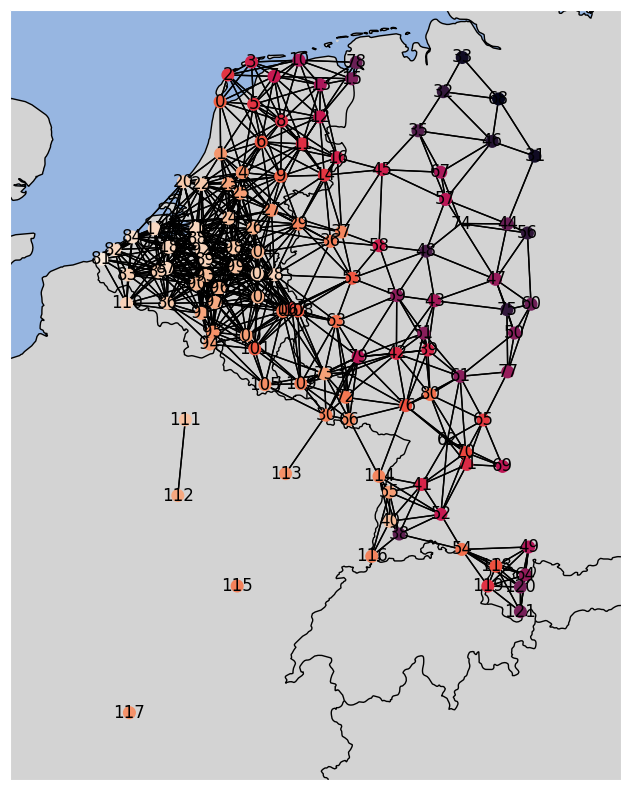

In [41]:
graph2 = Data(x=x, edge_index=g2_edge_idx.T, edge_attr=g2_edge_attr, timestamp=date, y=y)
#graph1
print(graph2.num_edges)
print(graph2.num_edge_features)
vis = to_networkx(graph2)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph2.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

In [ ]:
def create_graph2(max_geo: float, max_alt: float, date, ensemble, sum_stats):
    x, y, pos_dict, (lon, lat) = create_graph_data(date, ensemble, sum_stats)

    # distance matrices berechnen
    geo_dist = compute_mat(dfs['stations'], "geodesic")
    alt_dist = compute_mat(dfs["stations"], "altitude")

    # mask bestimmen based on edges
    geo_mask = get_adj(geo_dist, max_geo)
    g2_adj = torch.tensor(geo_mask)
    geo_d = torch.tensor(geo_dist).unsqueeze(dim = 2)
    alt_d = torch.tensor(alt_dist).unsqueeze(dim = 2)

    # attribute fuer diese mask laden

    dist_tensor = torch.cat([geo_d, alt_d], dim=2)
    g2_edges = np.array(np.argwhere(g2_adj))
    print(g2_edges.shape)
    g2_edge_idx = torch.tensor(g2_edges.T)
    g2_attr = dist_tensor[g2_adj]

    g2_edge_attr = g2_attr
    g2_edge_attr[:, 0] = g2_edge_attr[:, 0] / g2_edge_attr[:, 0].max()
    g2_edge_attr[:, 1] = g2_edge_attr[:, 1] / g2_edge_attr[:, 1].max()

    # check sizes:
    print(f"{df.station_id.nunique()} nodes and {np.sum(g2_adj.numpy())} edges")
    print(f"x: {x.shape}")
    print(f"edge_index: {g2_edge_idx.shape}")
    print(f"edge_attr: {g2_edge_attr.shape}")
    print(f"y: {y.shape}")
    print(f"pos: {pos.shape}")

    graph = Data(x=x, edge_index=g2_edge_idx.T, edge_attr=g2_edge_attr, timestamp=date, y=y)
    return graph, pos_dict

In [ ]:
graphX, pos_dict = create_graph2(max_geo=100, max_alt=10, date='1997-01-02', ensemble=0, sum_stats=False)
print(graphX.num_edges)
print(graphX.num_edge_features)
vis = to_networkx(graphX)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graphX.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Graph 3: alt + dist
edges based on dist + alt, num_attr = 2

In [28]:
max_geo = 100
geo_dist = compute_mat(dfs['stations'], "geodesic")
print(geo_dist)
geo_mask = get_adj(geo_dist, max_geo)
print(geo_mask.sum())

max_alt = 5 # in welcher einheit (meters above sea level)
alt_dist = compute_mat(dfs["stations"], "altitude")
print(alt_dist)
alt_mask = get_adj(alt_dist, max_dist=max_alt)
print(alt_mask.sum())

[[  0.          67.88302104  36.07414311 ... 717.54863254 739.55923355
  767.55524464]
 [ 67.88302104   0.         103.0930141  ... 659.66900567 683.69191062
  710.83747663]
 [ 36.07414311 103.0930141    0.         ... 743.23584479 763.87800296
  792.39252869]
 ...
 [717.54863254 659.66900567 743.23584479 ...   0.          44.37574719
   55.46816552]
 [739.55923355 683.69191062 763.87800296 ...  44.37574719   0.
   31.99306735]
 [767.55524464 710.83747663 792.39252869 ...  55.46816552  31.99306735
    0.        ]]
1420
[[    0.     -4.5     9.6 ...   437.8  1476.8  1585.8]
 [    4.5     0.     14.1 ...   442.3  1481.3  1590.3]
 [   -9.6   -14.1     0.  ...   428.2  1467.2  1576.2]
 ...
 [ -437.8  -442.3  -428.2 ...     0.   1039.   1148. ]
 [-1476.8 -1481.3 -1467.2 ... -1039.      0.    109. ]
 [-1585.8 -1590.3 -1576.2 ... -1148.   -109.      0. ]]
612


In [29]:
geo_adj = torch.tensor(geo_mask).unsqueeze(dim=2)
alt_adj = torch.tensor(alt_mask).unsqueeze(dim=2)
g3_tensor = torch.cat([geo_adj, alt_adj], dim=2)
g3_adj = g3_tensor.any(dim=2)
print(g3_adj.shape)

geo_d = torch.tensor(geo_dist).unsqueeze(dim=2)
alt_d = torch.tensor(alt_dist).unsqueeze(dim=2)
print(alt_d.shape)

std_geo_d = geo_d / geo_d.max()
std_alt_d = alt_d / alt_d.max()

dist_tensor = torch.cat([std_geo_d, std_alt_d], dim=2)
print(dist_tensor.shape)

torch.Size([122, 122])
torch.Size([122, 122, 1])
torch.Size([122, 122, 2])


In [30]:
# create edges
#adj_mat = g2_adj
g3_edges = np.array(np.argwhere(g3_adj))
print(g3_edges.shape)
g3_edge_idx = torch.tensor(g3_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {g3_edge_idx.shape}")
print(f"Edges: {g3_edge_idx}")
print(f"Total number of edges: {np.sum(g3_adj.numpy())}")

(2, 1846)
Edges shape: torch.Size([1846, 2])
Edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])
Total number of edges: 1846


In [31]:
# add attributes
g3_edge_attr = dist_tensor[g3_adj]

print(g3_edge_attr)
print(g3_edge_attr.shape)
print(g3_edge_attr.T[:2, :5])

tensor([[ 7.1109e-02, -2.8279e-03],
        [ 3.7789e-02,  6.0328e-03],
        [ 6.7031e-02, -3.1421e-04],
        ...,
        [ 7.0999e-02, -7.3085e-01],
        [ 5.8104e-02, -7.2142e-01],
        [ 3.3514e-02, -6.8497e-02]], dtype=torch.float64)
torch.Size([1846, 2])
tensor([[ 0.0711,  0.0378,  0.0670,  0.1006,  0.0426],
        [-0.0028,  0.0060, -0.0003,  0.0004, -0.0016]], dtype=torch.float64)


In [32]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(g3_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {g3_edge_idx.shape}")
print(f"edge_attr: {g3_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

122 nodes and 1846 edges
x: torch.Size([122, 34])
edge_index: torch.Size([1846, 2])
edge_attr: torch.Size([1846, 2])
y: torch.Size([122, 1])
pos: (122, 2)


1846
2
test


<Figure size 1000x1000 with 0 Axes>

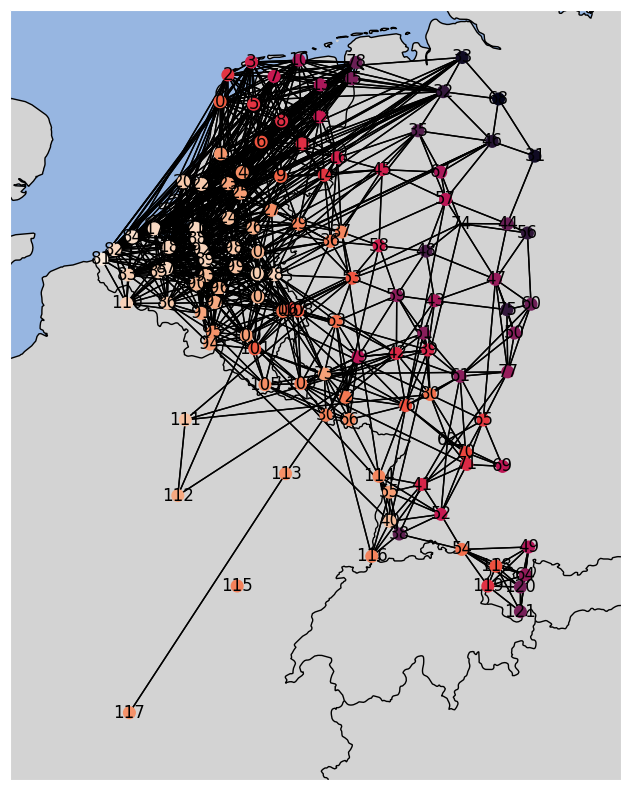

In [33]:
graph3 = Data(x=x, edge_index=g3_edge_idx.T, edge_attr=g3_edge_attr, timestamp=date, y=y)
print(graph3.num_edges)
print(graph3.num_edge_features)
vis = to_networkx(graph3)
plt.figure(1, figsize=(10, 10))
ax = plot_map()
nx.draw_networkx(vis, node_size=70, node_color=graph3.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()
# den Graph mit nur Altitude

## Alt - Orog

### Graph 1: alt-orog delta

In [103]:
max_altorog = 2
dfs['stations']['alt-orog'] = dfs['stations']['altitude'] - dfs['stations']['orog']
stations_df = dfs['stations']
print(stations_df)
altorog_dist = compute_mat(stations_df, "alt-orog")
print(altorog_dist)
altorog_mask = get_adj(altorog_dist, max_altorog)
print(altorog_mask.sum())
altorog_adj = torch.tensor(altorog_mask)
altorog_d = torch.tensor(altorog_dist)
#print(altorog_d.shape)


     station_id        lat        lon  altitude         orog  \
0           235  52.928000   4.781000       1.2    -1.706008   
1           240  52.318000   4.790000      -3.3    -1.298122   
2           242  53.241000   4.921000      10.8     0.333424   
3           251  53.392000   5.346000       0.7     1.302155   
4           260  52.100000   5.180000       1.9     2.576800   
..          ...        ...        ...       ...          ...   
117        7460  45.786833   3.149333     331.0   521.714299   
118       11101  47.499168   9.746111     424.0   689.253673   
119       11105  47.266666   9.600000     439.0   972.938723   
120       11308  47.255833  10.186111    1478.0  1752.460782   
121       11312  46.968056  10.185555    1587.0  2105.435549   

                     name    alt-orog  
0                 De Kooy    2.906008  
1                Schiphol   -2.001878  
2                Vlieland   10.466576  
3    Hoorn (Terschelling)   -0.602155  
4                 De Bilt   -0.

(2, 514)
Edges shape: torch.Size([514, 2])
Edges: tensor([[  0,   7],
        [  0,   8],
        [  0,  10],
        ...,
        [114,  36],
        [114,  57],
        [114,  62]])
Total number of edges: 514
tensor([[ 9.9129e-04],
        [-1.5171e-03],
        [-2.2432e-04],
        [ 1.3265e-03],
        [ 6.2676e-04],
        [-1.4762e-03],
        [ 6.7071e-04],
        [-8.3275e-04],
        [-8.2996e-04],
        [ 1.0886e-03],
        [ 1.0305e-03],
        [-7.8404e-04],
        [ 2.8369e-04],
        [-1.5333e-03],
        [ 1.4196e-03],
        [-1.4565e-03],
        [ 8.7083e-04],
        [ 9.2995e-04],
        [-7.5193e-04],
        [ 2.8106e-04],
        [ 1.4048e-03],
        [-5.1918e-04],
        [ 1.2042e-03],
        [-7.5642e-04],
        [-4.6880e-04],
        [ 6.1756e-04],
        [ 3.8739e-04],
        [-1.0905e-03],
        [-1.3884e-03],
        [-1.0886e-03],
        [-5.8051e-05],
        [-8.0487e-04],
        [ 1.2112e-03],
        [ 3.3101e-04],
       

/tmp/ipykernel_3827865/1601438198.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  altorog_edge_attr = torch.tensor(altorog_edge_attr.reshape(-1, 1))


<Figure size 1000x1000 with 0 Axes>

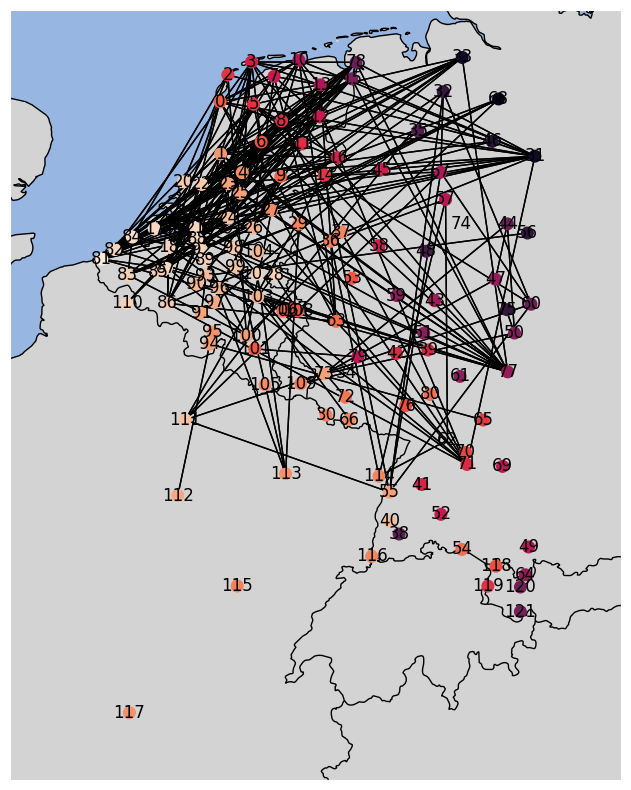

In [104]:
std_altorog_d = altorog_d / altorog_d.max() # standardisiere erst nach mask application
# create edges
altorog_edges = np.array(np.argwhere(altorog_adj))
print(altorog_edges.shape)
altorog_edge_idx = torch.tensor(altorog_edges.T)  # torch.Size([1420, 2])

print(f"Edges shape: {altorog_edge_idx.shape}")
print(f"Edges: {altorog_edge_idx}")
print(f"Total number of edges: {np.sum(altorog_adj.numpy())}")
# add attributes
altorog_edge_attr = std_altorog_d[altorog_adj]
altorog_edge_attr = torch.tensor(altorog_edge_attr.reshape(-1, 1))
print(altorog_edge_attr)
print(altorog_edge_attr.shape)
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(altorog_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {altorog_edge_idx.shape}")
print(f"edge_attr: {altorog_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")
graph_altorog = Data(x=x, edge_index=altorog_edge_idx.T, edge_attr=altorog_edge_attr, timestamp=date, y=y)
#graph1
print(graph_altorog.num_edges)
print(graph_altorog.num_edge_features)
vis = to_networkx(graph_altorog)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size=70, node_color=graph_altorog.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Graph 2: alt-orog-delta + dist

## Using distance metrics from Paper
"Similarity-based semilocal estimation of postprocessing models" by Lerch & Baran

In [47]:
print(df[df['station_id']==0]['t2m'])
print(np.concatenate((data_sorted.reshape(-1, 1), cdf.reshape(-1, 1)), axis=1))

0          278.928619
122        279.224365
244        279.468384
366        279.233154
488        279.048187
              ...    
4626606    273.074860
4626728    272.469421
4626850    272.283936
4626972    271.919861
4627094    272.866516
Name: t2m, Length: 37928, dtype: float32
[[2.68972168e+02 0.00000000e+00]
 [2.69065826e+02 2.63657456e-05]
 [2.69144043e+02 5.27314912e-05]
 ...
 [2.95806396e+02 9.99920903e-01]
 [2.96102295e+02 9.99947269e-01]
 [2.96286621e+02 9.99973634e-01]]


<class 'numpy.ndarray'>


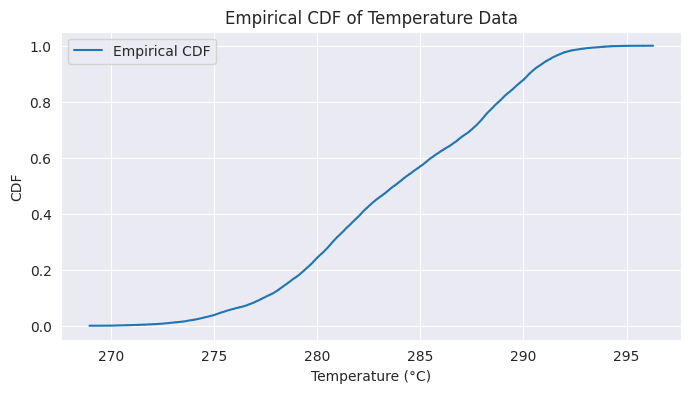

In [4]:
# for each station over the whole time period
this_station = 0
station_0_temps = df[df['station_id']==0]['t2m']
data_sorted = np.sort(station_0_temps)
cdf = np.arange(len(data_sorted)) / len(data_sorted)
print(type(data_sorted))

plt.figure(figsize=(8, 4))
plt.step(data_sorted, cdf, where='post', label='Empirical CDF')
plt.title('Empirical CDF of Temperature Data')
plt.xlabel('Temperature (°C)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
print(df['t2m'].min())
print(df['t2m'].max())
S = np.arange(df['t2m'].min(), df['t2m'].max(), 1)
#S = np.arange(df['t2m'].min(), df['t2m'].max(), (df['t2m'].min() + df['t2m'].max())/100)
S.shape

241.29343
301.62183


(61,)

In [6]:
train_set = dfs['train'][0]
def create_emp_cdf(station_temps):
    data_sorted = np.sort(station_temps)
    cdf = np.arange(len(data_sorted)) / len(data_sorted)
    cdf_function = interp1d(data_sorted, cdf, kind='previous', bounds_error=False, fill_value=(0, 1))
    return cdf_function

(61,)


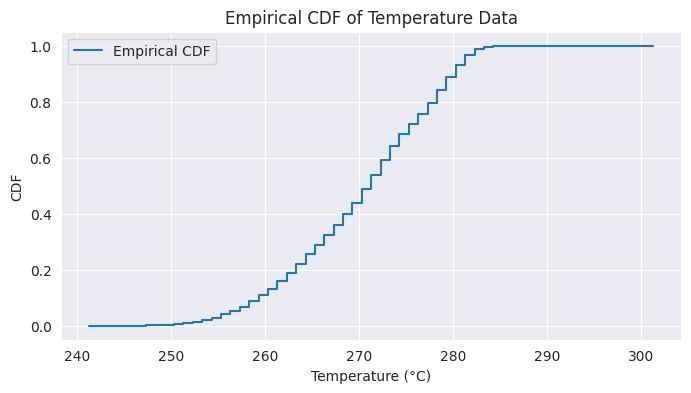

In [7]:
# check if get_emp_cdf works
S = np.arange(train_set['t2m'].min(), train_set['t2m'].max(), 1) #1th and 99th percentile? => Anzahl Schritte statt Schritgroesse? => equidistant
#cdf_values = create_emp_cdf(train_set['t2m'])(S)
temps = train_set[train_set['station_id'] == 121]['t2m']
cdf_values = create_emp_cdf(temps)(S)
print(cdf_values.shape)

plt.figure(figsize=(8, 4))
plt.step(S.T, cdf_values, where='post', label='Empirical CDF')
plt.title('Empirical CDF of Temperature Data')
plt.xlabel('Temperature (°C)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()

In [122]:
# train_set = dfs['train'][0] # irgendwie hat das nicht funktioniert als parameter

def create_emp_cdf(station_temps):  # F_i(x)
    data_sorted = np.sort(station_temps)
    cdf = np.arange(len(data_sorted)) / len(data_sorted)
    cdf_function = interp1d(data_sorted, cdf, kind='previous', bounds_error=False, fill_value=(0, 1))
    return cdf_function

def dist2(i_id, j_id, train_set):
# def dist2(i_id, j_id):
    print(i_id, j_id)
    i_train_temps = train_set[train_set['station_id'] == i_id]['t2m']
    j_train_temps = train_set[train_set['station_id'] == j_id]['t2m']
    F_i = create_emp_cdf(i_train_temps)
    F_j = create_emp_cdf(j_train_temps)
    sum = 0
    S = np.arange(train_set['t2m'].min(), train_set['t2m'].max(), 1)
    for x in S:
        sum += abs(F_i(x) - F_j(x))
    d2 = sum * 1/S.shape[0]
    return d2

# def compute_d2_matrix(stations: pd.DataFrame, df: pd.DataFrame) -> np.array:
    # macht es Sinn, dass trainset hier hinzugegeben wird fuer die graphenerstellung?
def compute_d2_matrix(stations: pd.DataFrame) -> np.array:
    station_id = np.array(stations.index).reshape(-1, 1)
    print(station_id.shape)
    print(station_id.T.shape)
    vectorized_dist2 = np.vectorize(dist2, excluded=[2])
    distance_matrix = vectorized_dist2(station_id, station_id.T, dfs['train'][0])
    # distance_matrix = np.vectorize(dist2)(station_id, station_id.T)
    return distance_matrix

def load_d2_distances(stations: pd.DataFrame) -> np.ndarray:
    if os.path.exists("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy"):
        print("[INFO] Loading distances from file...")
        mat = np.load("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy")
    else:
        print("[INFO] Computing distances...")
        mat = compute_d2_matrix(stations)
        np.save("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy", mat)
    return mat

In [83]:
# check if dist2 works
print(dist2(0, 1, dfs['train'][0]))

0 1
0.027451927897897997


In [81]:
print(os.path.exists("/mnt/sda/Data2/gnnpp-data/d2_distances_EUPP.npy"))
d2_dist = load_d2_distances(dfs['stations'])
print(d2_dist)
print(d2_dist.max()) # macht das sinn, dass maximum nur 0.2.. ist?

True
[INFO] Loading distances from file...
[[0.         0.02745193 0.00399938 ... 0.13125776 0.20205843 0.23128119]
 [0.02745193 0.         0.03144699 ... 0.10390784 0.17470851 0.20393126]
 [0.00399938 0.03144699 0.         ... 0.13525282 0.20605349 0.23527624]
 ...
 [0.13125776 0.10390784 0.13525282 ... 0.         0.07080067 0.10002343]
 [0.20205843 0.17470851 0.20605349 ... 0.07080067 0.         0.02922276]
 [0.23128119 0.20393126 0.23527624 ... 0.10002343 0.02922276 0.        ]]
0.23527624385807794


In [79]:
max_d2 = 0.004
d2_mask = get_adj(d2_dist, max_d2)
print(d2_mask.sum())
print(d2_dist.shape)

928
(122, 122)


In [89]:
d2_adj = torch.tensor(d2_mask)
d2_d = torch.tensor(d2_dist)
print(d2_d.shape)

torch.Size([122, 122])


In [90]:
# create edges
d2_edges = np.array(np.argwhere(d2_adj))
print(d2_edges.shape)
d2_edge_idx = torch.tensor(d2_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {d2_edge_idx.shape}")
print(f"Edges: {d2_edge_idx}")
print(f"Total number of edges: {np.sum(d2_adj.numpy())}")

(2, 928)
Edges shape: torch.Size([928, 2])
Edges: tensor([[  0,   2],
        [  0,   3],
        [  0,  20],
        ...,
        [117,  68],
        [117,  94],
        [117, 100]])
Total number of edges: 928


In [93]:
# add attributes
d2_edge_attr = d2_d[d2_adj]
d2_edge_attr = torch.tensor(d2_edge_attr.reshape(-1, 1))
print(d2_edge_attr)
print(d2_edge_attr.shape)
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(d2_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {d2_edge_idx.shape}")
print(f"edge_attr: {d2_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")


tensor([[0.0040],
        [0.0015],
        [0.0019],
        [0.0019],
        [0.0023],
        [0.0018],
        [0.0038],
        [0.0011],
        [0.0021],
        [0.0026],
        [0.0026],
        [0.0036],
        [0.0024],
        [0.0040],
        [0.0027],
        [0.0015],
        [0.0027],
        [0.0031],
        [0.0038],
        [0.0018],
        [0.0011],
        [0.0012],
        [0.0027],
        [0.0027],
        [0.0022],
        [0.0027],
        [0.0035],
        [0.0018],
        [0.0035],
        [0.0038],
        [0.0030],
        [0.0017],
        [0.0033],
        [0.0030],
        [0.0022],
        [0.0023],
        [0.0033],
        [0.0032],
        [0.0037],
        [0.0019],
        [0.0029],
        [0.0029],
        [0.0019],
        [0.0037],
        [0.0023],
        [0.0037],
        [0.0028],
        [0.0033],
        [0.0020],
        [0.0011],
        [0.0034],
        [0.0015],
        [0.0024],
        [0.0024],
        [0.0038],
        [0

/tmp/ipykernel_3827865/2503993675.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d2_edge_attr = torch.tensor(d2_edge_attr.reshape(-1, 1))


928
1
test


<Figure size 1000x1000 with 0 Axes>

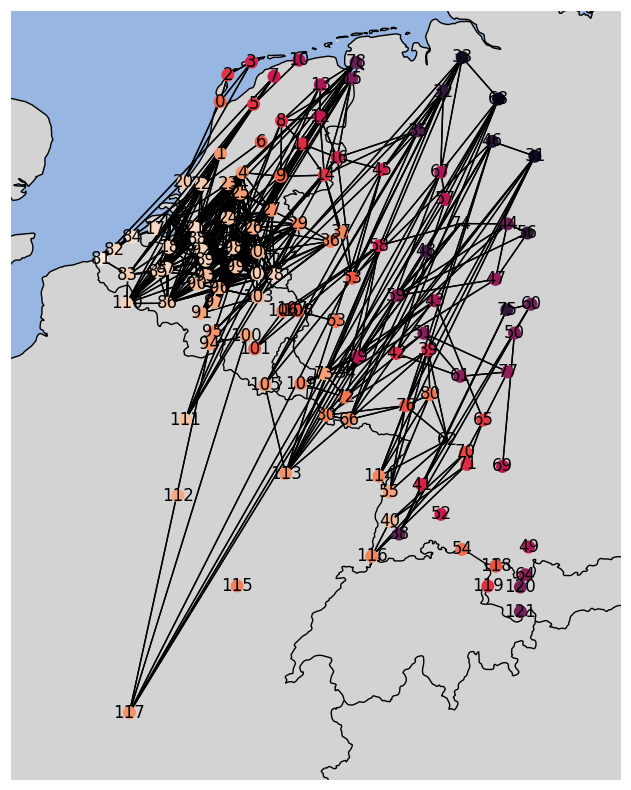

In [94]:
graph_d2 = Data(x=x, edge_index=d2_edge_idx.T, edge_attr=d2_edge_attr, timestamp=date, y=y)
#graph1
print(graph_d2.num_edges)
print(graph_d2.num_edge_features)
vis = to_networkx(graph_d2)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size=70, node_color=graph_d2.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Distance metric 3

In [133]:
# G_i plotten

def create_emp_cdf_of_errors(station_df, target_temp): # cdfs v
    # given station i:
    #for each date t: calculate ensemble mean
    # ensemble mean per date:
    f_bar = station_df.groupby(['time'])['t2m'].mean()
    # print(f_bar.shape)
    # print(target_temp.shape)
    def cdf_functions(z):
        return (1/ station_df.nunique()['time']) * np.sum(f_bar.to_numpy() - target_temp.to_numpy() <= z)
    return cdf_functions

def dist3(i_id, j_id, cdfs):
    print(i_id, j_id)
    # i_train = train_set[train_set['station_id'] == i_id]
    # j_train = train_set[train_set['station_id'] == j_id]
    # i_target_temps = train_target_set[train_target_set['station_id'] == i_id]['t2m'] # given station hier als condition
    # j_target_temps = train_target_set[train_target_set['station_id'] == j_id]['t2m']
    # G_i = create_emp_cdf_of_errors(i_train, i_target_temps)
    # G_j = create_emp_cdf_of_errors(j_train, j_target_temps)
    sum = 0
    S = np.arange(-10, 10, 0.5)
    for x in S:
        sum += abs(cdfs[i_id](x) - cdfs[j_id](x))
    d3 = sum * 1/S.shape[0]
    return d3

def compute_d3_matrix(stations: pd.DataFrame, train_set, train_target_set) -> np.array:
    station_id = np.array(stations.index).reshape(-1, 1)
    cdfs = []
    for i_id in range(0, 122):
        i_train = train_set[train_set['station_id'] == i_id]
        i_target_temps = train_target_set[train_target_set['station_id'] == i_id]['t2m']
        G_s = create_emp_cdf_of_errors(i_train, i_target_temps)
        cdfs.append(G_s)
    print("[INFO] Cdfs created.")
    # print(station_id.shape)
    # print(station_id.T.shape)
    vectorized_dist3 = np.vectorize(dist3, excluded=[2])
    distance_matrix = vectorized_dist3(station_id, station_id.T, cdfs)
    return distance_matrix

def load_d3_distances(stations: pd.DataFrame, train_set, train_target_set) -> np.ndarray:
    if os.path.exists("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy"):
        print("[INFO] Loading distances from file...")
        mat = np.load("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy")
    else:
        print("[INFO] Computing distances...")
        mat = compute_d3_matrix(stations, train_set, train_target_set)
        np.save("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy", mat)
    return mat

In [104]:
cdfs = []
train_set = dfs['train'][0]
train_target_set = dfs['train'][1]
for i_id in range(0, 122):
    i_train = train_set[train_set['station_id'] == i_id]
    i_target_temps = train_target_set[train_target_set['station_id'] == i_id]['t2m']
    G_s = create_emp_cdf_of_errors(i_train, i_target_temps)
    cdfs.append(G_s)
cdfs[0](0)

0.21519721577726217

In [7]:

print(dist3(7, 5, cdfs))
id = 0
i_train = train_set[train_set['station_id'] == id]
i_target_temps = train_target_set[train_target_set['station_id'] == id]['t2m']
#print(i_train.groupby(['time'])['t2m'].mean())
#print(i_target_temps)
f_bar = i_train.groupby(['time'])['t2m'].mean()
print(f_bar.to_numpy() - i_target_temps.to_numpy())
print((np.abs(f_bar.to_numpy() - i_target_temps.to_numpy()) <= 10).any())


7 5
0.014254640371229707
[ 1.43380737  3.99249878  0.81829224 ... -1.22086792  2.5793335
  1.28786621]
True


(37928, 36)
(3448,)
(40,)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.80046404e-04 8.70069606e-04
 1.74013921e-03 3.48027842e-03 6.96055684e-03 1.24709977e-02
 2.63921114e-02 5.13341067e-02 1.01798144e-01 1.86194896e-01
 3.36716937e-01 4.97969838e-01 6.58352668e-01 7.79002320e-01
 8.61948956e-01 9.15313225e-01 9.53306265e-01 9.71867749e-01
 9.84338747e-01 9.91299304e-01 9.94199536e-01 9.97969838e-01
 9.99129930e-01 9.99709977e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]


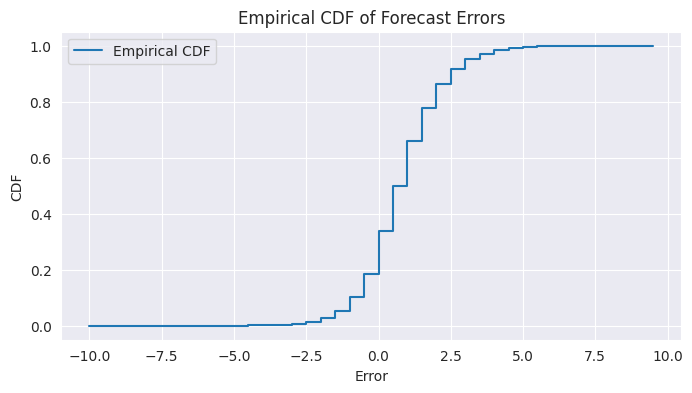

In [8]:
# check if get_emp_cdf works
id = 7
S = np.arange(-10, 10, 0.5)
i_train = train_set[train_set['station_id'] == id]
i_target_temps = train_target_set[train_target_set['station_id'] == id]['t2m']
print(i_train.shape)
print(i_target_temps.shape)
print(S.shape)
cdf_values = np.zeros(S.shape)
for idx, x in enumerate(S):
    value = create_emp_cdf_of_errors(i_train, i_target_temps)(x)
    cdf_values[idx] = value
print(cdf_values)
# print(cdf_values.shape)

plt.figure(figsize=(8, 4))
plt.step(S.T, cdf_values, where='post', label='Empirical CDF')
plt.title('Empirical CDF of Forecast Errors')
plt.xlabel('Error')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.show()

In [121]:
print(os.path.exists("/mnt/sda/Data2/gnnpp-data/d3_distances_EUPP.npy")) # sehr sehr langsam... => in separater Python File laufen lassen?
d3_dist = load_d3_distances(dfs['stations'], dfs['train'][0], dfs['train'][1])
print(d3_dist)
print(d3_dist.max()) # macht das sinn, dass maximum nur 0.2.. ist?

False
[INFO] Computing distances...
[INFO] Cdfs created.
0 0
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


KeyboardInterrupt: 